In [1]:
# preparing the tools
import re
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

# Spam or not

This project explore text message data and predict if a message is spam or not.

## 1. Data 

`spam.csv` contains text message and target indicates spam message.

## 2. Problem Definition

To create a prediction project we should:
* a. Clear and split data on train and test sets.
* b. Extract features.
* c. Create and fit sklearn classifier.

### a. Data Analysis

In [2]:
spam_data = pd.read_csv('spam.csv')
spam_data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


Let's convert `target` column into numeric format:
* 0, if message isn't spam
* 1, if message is spam

In [3]:
# rewrite a target column
spam_data['target'] = np.where(spam_data['target'] == 'spam', 1, 0)
spam_data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Let's find out what percentage of the documents in spam_data are spam?

<IPython.core.display.Javascript object>


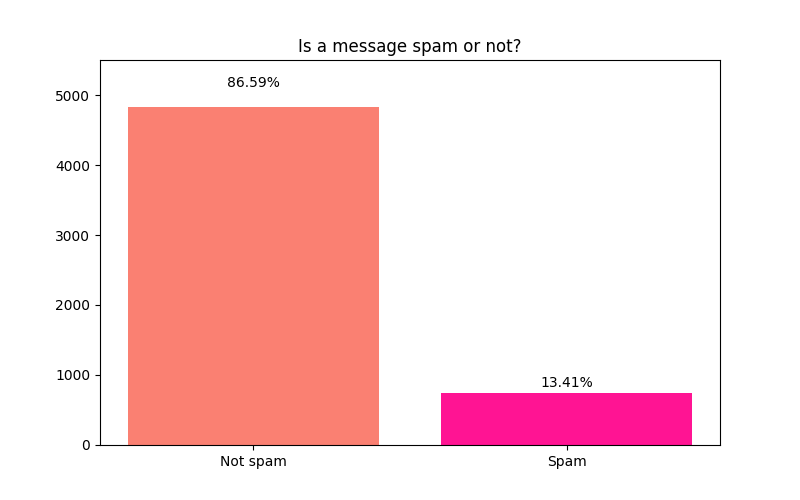

In [4]:
spam_or_not = spam_data['target'].value_counts()
perc_spam = 100 * spam_or_not[1] / (spam_or_not[0] + spam_or_not[1])
perc_spam = float(f"{perc_spam:.{2}f}")
perc_not_spam = 100 - perc_spam

fig, ax = plt.subplots(figsize=(8, 5))
bar_label = [str(perc_not_spam) + '%', str(perc_spam) + '%']

bar_plot = plt.bar([0,1], spam_or_not, tick_label=['Not spam', 'Spam'], color=['salmon', 'deeppink'])

for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            bar_label[idx],
            ha='center', va='bottom', rotation=0)
    
plt.ylim(0,5500)
plt.title('Is a message spam or not?')
plt.show()

Now, we should split data on train and test splits.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], spam_data['target'], 
                                                    random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4179,), (1393,), (4179,), (1393,))

### b. Extract features

We will use two methods:
* Count Vectorizer - ignoring terms that have a document frequency strictly lower than 5 and using character n-grams from n=2 to n=5.
* Tfidf Vectorizer - ignoring terms that have a document frequency strictly lower than 5 and using word n-grams from n=1 to n=3 (unigrams, bigrams, and trigrams)

In [6]:
count_vectorizer = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=(2,5)).fit(X_train)
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)

Let's transform the X_data using created vectorizers.

In [7]:
# Count Vectorizer
X_train_count_vectorized = count_vectorizer.transform(X_train)
X_test_count_vectorized = count_vectorizer.transform(X_test)

# Tfidf Vectorizer
X_train_tfidf_vectorized = tfidf_vectorizer.transform(X_train)
X_test_tfidf_vectorized = tfidf_vectorizer.transform(X_test)

### c. Create and fit model

Create a function to combine new features into the X-data.

In [8]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

Using features matrix and the following additional features:
* the length of document (number of characters)
* number of digits per document
* **number of non-word characters (anything other than a letter, digit or underscore.)**

In [9]:
def get_len_of_doc(X):
    """
    Returns the list of lengths of each row in X.
    """
    len_of_document = []
    for row in X:
        len_of_document.append(len(row))
    return len_of_document
    
def get_num_of_digits(X):
    """
    Returns the list of number of digits of each row in X.
    """
    num_of_digits = []
    for row in X:
        nums = 0
        for ch in row:
            if ch.isdigit():
                nums += 1
        num_of_digits.append(nums)
    return num_of_digits
    
def num_of_non_word(X):
    """
    Returns the list of number of non-word characters of each row in X.
    """
    num_of_non_word = []
    for row in X:
        num_of_non_word.append(len(re.findall(r'\W', row)))
    return num_of_non_word

Adding features.

In [10]:
# Count Vectorizer
# Train data
X_train_count_add = add_feature(X_train_count_vectorized, get_len_of_doc(X_train))
X_train_count_add = add_feature(X_train_count_add, get_num_of_digits(X_train))
X_train_count_add = add_feature(X_train_count_add, num_of_non_word(X_train))
# Test data
X_test_count_add = add_feature(X_test_count_vectorized, get_len_of_doc(X_test))
X_test_count_add = add_feature(X_test_count_add, get_num_of_digits(X_test))
X_test_count_add = add_feature(X_test_count_add, num_of_non_word(X_test))

# Tfidf Vectorizer
# Train data
X_train_tfidf_add = add_feature(X_train_tfidf_vectorized, get_len_of_doc(X_train))
X_train_tfidf_add = add_feature(X_train_tfidf_add, get_num_of_digits(X_train))
X_train_tfidf_add = add_feature(X_train_tfidf_add, num_of_non_word(X_train))
# Test data
X_test_tfidf_add = add_feature(X_test_tfidf_vectorized, get_len_of_doc(X_test))
X_test_tfidf_add = add_feature(X_test_tfidf_add, get_num_of_digits(X_test))
X_test_tfidf_add = add_feature(X_test_tfidf_add, num_of_non_word(X_test))

Let's use next models:
* MultinomialNB
* SVC
* LogisticRegression

Evaluation metric is the area under the curve (AUC) score.

In [11]:
models = {'LogisticRegression' : LogisticRegression(C=100),
          'MultinomialNB' : MultinomialNB(alpha=0.1),
          'SVC' : SVC(C=10000)
          }

auc_scores = {}

for key, model in models.items():
    # fit each model and making predictions
    prediction_count = model.fit(X_train_count_add, y_train).predict(X_test_count_add)
    prediction_tfidf = model.fit(X_train_tfidf_add, y_train).predict(X_test_tfidf_add)
    
    # evaluation
    auc_count = roc_auc_score(y_test, prediction_count)
    auc_tfidf = roc_auc_score(y_test, prediction_tfidf)
    auc_scores[key] = {'Count Vectorizer' : auc_count, 'Tfidf Vectorizer' : auc_tfidf}
    
    print(f'{key} model :')
    print(f'AUC score for Count Vectorizer = {auc_count}')
    print(f'AUC score for Tfidf Vectorizer = {auc_tfidf}')  
    print()

LogisticRegression model :
AUC score for Count Vectorizer = 0.9788593110707434
AUC score for Tfidf Vectorizer = 0.9678709064054463

MultinomialNB model :
AUC score for Count Vectorizer = 0.9818451521993787
AUC score for Tfidf Vectorizer = 0.9408476648048486

SVC model :
AUC score for Count Vectorizer = 0.9792773712714121
AUC score for Tfidf Vectorizer = 0.9712450978727738



<IPython.core.display.Javascript object>


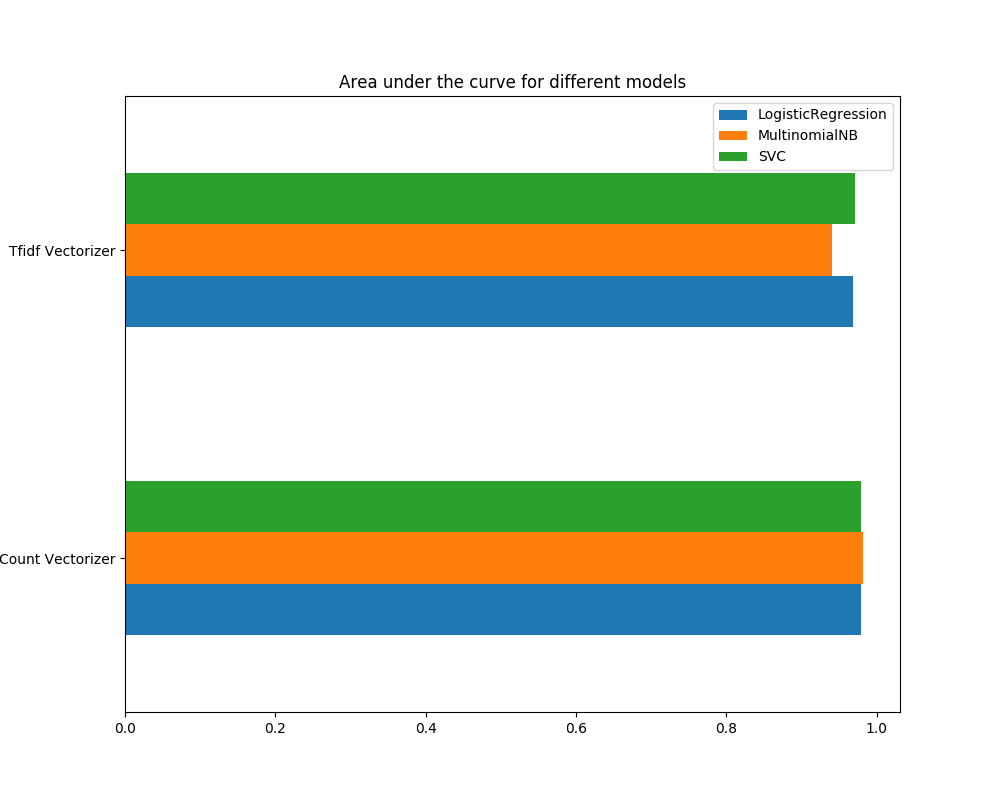

In [12]:
compare_metrics = pd.DataFrame(auc_scores)
compare_metrics.plot.barh(figsize=(10, 8));
plt.xticks(rotation=0);
plt.title('Area under the curve for different models')
plt.show()